In [1]:
!pip install --proxy=http://internet.ford.com:83 pyreadstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 4.5 MB/s eta 0:00:00a 0:00:010m


In [2]:
!pip install --proxy=http://internet.ford.com:83 gaminet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 3.7 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 1.4 MB/s eta 0:00:0000:0100:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.0/237.0 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 9.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 7.2 MB/s eta 0:00:0000:0100:01mm
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.2/75.2 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 7.3 MB/s eta 0:00:0000:0100:01mm
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 7.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 M

In [3]:
!pip install --proxy=http://internet.ford.com:83 xlwt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 807.5 kB/s eta 0:00:00a 0:00:01


In [1]:
import pandas as pd
import numpy as np
import pyreadstat
import re
import os

import tensorflow as tf
import json
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, roc_auc_score

from gaminet import GAMINet
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

2022-11-17 04:23:26.047499: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 04:23:26.245020: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-17 04:23:27.141406: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-11-17 04:23:27.141525: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer

In [2]:
df, meta = pyreadstat.read_sas7bdat('uk_comm_ptrans_data.sas7bdat')
print(df.values.shape)

(20980, 83)


In [3]:
cols = meta.column_names
# temp_df = (df.mean() >= 1)
# print(temp_df.values.shape)
date_cols = [i for i in cols if "date" in i]
print(date_cols)
# print(df[date_cols].value_counts())
# print(*cols, sep="\n")

['applic_date', 'purchase_date', 'date_into_lru']


In [4]:
def cat_or_num(col):
    if(df["odefind_new"].value_counts().shape[0] == 2):
        return {"type":"categorical"}
    else:
        return {"type":"continuous"}

meta_info = {}
col_odefind1 = None
for col in sorted(cols):
    if(col != "odefind1" and col not in date_cols):
        meta_info[col] = cat_or_num(col)
    else:
        try:
            req = df.pop(col)
            if(col == "odefind1"):
                df["odefind1"] = req
        except Exception:
            print("Already popped")
meta_info["odefind1"] = {"type":"target"}
print(meta_info)
print(len(meta_info))

{'acidtest_1': {'type': 'categorical'}, 'advance_pct': {'type': 'categorical'}, 'avgterm': {'type': 'categorical'}, 'balloon_amt': {'type': 'categorical'}, 'balloon_ind': {'type': 'categorical'}, 'business': {'type': 'categorical'}, 'capitalemployed_1': {'type': 'categorical'}, 'ccjtoshftotl24m_1': {'type': 'categorical'}, 'compage_1': {'type': 'categorical'}, 'compavgdbt_12mth_1': {'type': 'categorical'}, 'compavgdbt_3mth_1': {'type': 'categorical'}, 'compavgdbt_6mth_1': {'type': 'categorical'}, 'compdbt_1': {'type': 'categorical'}, 'compnumdbt_100000_1': {'type': 'categorical'}, 'compnumdbt_10000_1': {'type': 'categorical'}, 'compunpaccs_1': {'type': 'categorical'}, 'country': {'type': 'categorical'}, 'creditlimit_1': {'type': 'categorical'}, 'currentliabilitiestotal_1': {'type': 'categorical'}, 'curtoprevdirlst12mth_1': {'type': 'categorical'}, 'dl12_regnumber_1': {'type': 'categorical'}, 'dl41_supppaypattn_1': {'type': 'categorical'}, 'dl77_creditrating_1': {'type': 'categorical'},

In [5]:
nan_cols = pd.DataFrame(df.isna().sum())
nan100_cols = pd.DataFrame(df.isna().sum()*100/df.values.shape[0])
print(nan100_cols)
nan_df = pd.concat([nan_cols, nan100_cols], axis=1, join='inner')
print(nan_df)
nan_df.to_excel("information.xls", sheet_name="Nan_Columns")

                                0
scope_refno              0.000000
advance_pct              0.000000
balloon_amt              0.000000
final_term               0.000000
time_in_business         0.000000
...                           ...
percapptslst12mth_1      0.934223
numccls_1                0.934223
compunpaccs_1           28.517636
numunpaidacctslstmth_1   3.112488
odefind1                 0.000000

[80 rows x 1 columns]
                           0          0
scope_refno                0   0.000000
advance_pct                0   0.000000
balloon_amt                0   0.000000
final_term                 0   0.000000
time_in_business           0   0.000000
...                      ...        ...
percapptslst12mth_1      196   0.934223
numccls_1                196   0.934223
compunpaccs_1           5983  28.517636
numunpaidacctslstmth_1   653   3.112488
odefind1                   0   0.000000

[80 rows x 2 columns]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  


### Imputing and Removing specified colums:
1. Remove ```compnumdbt_100000_1``` and ```scope_refno```
1. Imputing remaining

In [6]:
remove_cols = ["compnumdbt_10000_1", "scope_refno"]
try:
    for i in remove_cols:
        meta_info.pop(i)
        df.pop(i)
except Exception:
    print("Already popped")
print(df.values.shape, len(meta_info))

(20980, 78) 78


In [7]:
# Imputed!!
for i, (key, value) in enumerate(meta_info.items()):
    if(value["type"] == "categorical"):
        df[key].fillna(df[key].mode()[0], inplace=True)
    else:
        df[key].fillna(df[key].mean(), inplace=True)


In [8]:
x, y = df.iloc[:,:-1].values, df.iloc[:,[-1]].values

print(x.shape, y.shape)

xx = np.zeros((x.shape[0], x.shape[1]), dtype=np.float32)
for i, (key, item) in enumerate(meta_info.items()):
    if item['type'] == 'target':
        sy = MinMaxScaler((0,1))
        y = sy.fit_transform(y)
        meta_info[key]['scaler'] = sy
    elif item['type'] == 'categorical':
        enc = OrdinalEncoder()
        xx[:,[i]] = enc.fit_transform(x[:,[i]])
        meta_info[key]['values'] = []
        for item in enc.categories_[0].tolist():
            try:
                if item == int(item):
                    meta_info[key]['values'].append(str(int(item)))
                else:
                    meta_info[key]['values'].append(str(item))
            except ValueError:
                meta_info[key]['values'].append(str(item))
    else:
        sx = MinMaxScaler((0, 1))
        xx[:,[i]] = sx.fit_transform(x[:,[i]])
        meta_info[key]['scaler'] = sx

task_type = 'Regression'
train_x, test_x, train_y, test_y = train_test_split(xx.astype(np.float32), y, test_size=0.3, random_state=0)
print(train_x.shape, train_y.shape)

(20980, 77) (20980, 1)
(14686, 77) (14686, 1)


In [9]:
def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def ras(label, pred, scaler=None):
    return r2_score(label, pred)

get_metric = metric_wrapper(ras, None)

=================================================

In [10]:
model = GAMINet(meta_info=meta_info, interact_num=30, 
                interact_arch=[100] * 5, subnet_arch=[100] * 5, 
                batch_size=100, task_type=task_type, activation_func=tf.nn.relu,
                main_effect_epochs=50, interaction_epochs=50, tuning_epochs=100, 
                lr_bp=[0.0001, 0.0001, 0.0001], early_stop_thres=[50, 50, 50],
                heredity=True, loss_threshold=0.01, reg_clarity=0.1,
                mono_increasing_list=[], mono_decreasing_list=[], ## the indices list of features
                verbose=True, val_ratio=0.2, random_state=0)

model.fit(train_x, train_y)

2022-11-17 04:23:41.849639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 04:23:41.851578: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 04:23:41.905449: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-11-17 04:23:41.917441: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow 

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.81950, val loss: 0.82028
Main effects training epoch: 2, train loss: 0.61829, val loss: 0.62054
Main effects training epoch: 3, train loss: 0.41855, val loss: 0.42206
Main effects training epoch: 4, train loss: 0.24927, val loss: 0.25347
Main effects training epoch: 5, train loss: 0.12840, val loss: 0.13255
Main effects training epoch: 6, train loss: 0.05725, val loss: 0.06075
Main effects training epoch: 7, train loss: 0.02343, val loss: 0.02604
Main effects training epoch: 8, train loss: 0.01066, val loss: 0.01248
Main effects training epoch: 9, train loss: 0.00668, val loss: 0.00797
Main effects training epoch: 10, train loss: 0.00549, val loss: 0.00649
Main effects training epoch: 11, train loss: 0.00503, val loss: 0.00589
Main effects training epoch: 12, train loss: 0.00475, val loss: 0.00556
Main effects training e

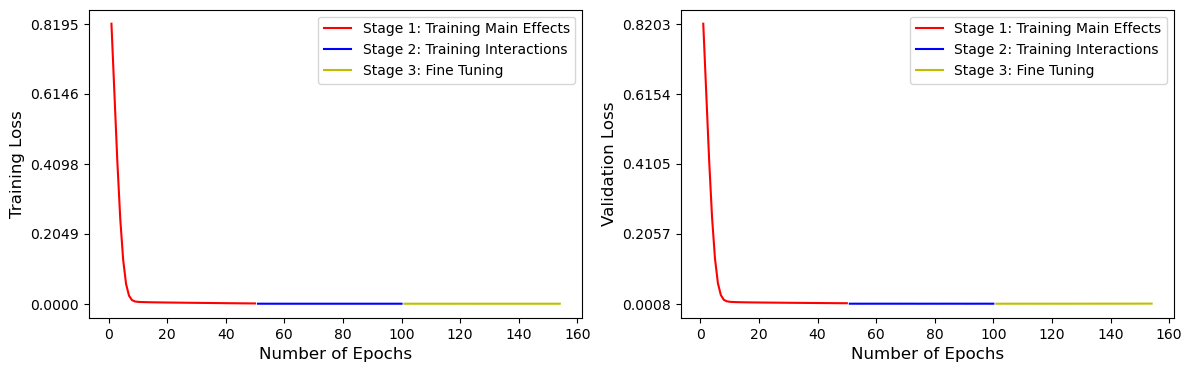

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


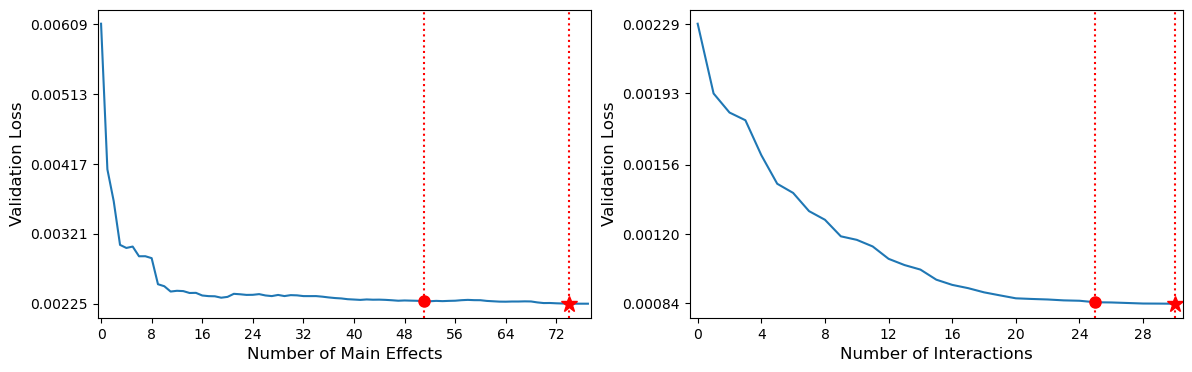

In [11]:
folder = "./imgs/"
if not os.path.exists(folder):
    os.makedirs(folder)
data_dict_logs = model.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=folder, name="DATASET_TRAJ", save_png=True, save_eps=True, log_scale=False)
plot_regularization(data_dict_logs, folder=folder, name="DATASET_REGU", save_png=True, save_eps=True, log_scale=False)

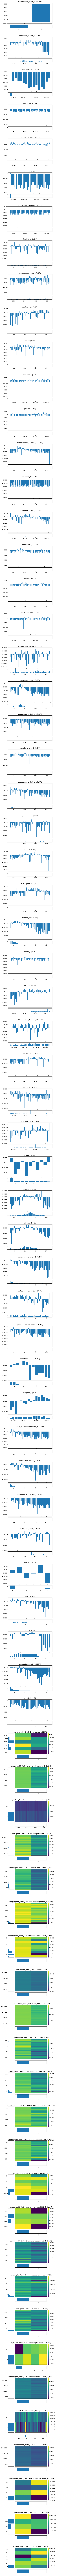

In [12]:
data_dict_global = model.global_explain(save_dict=True, folder=folder, name="gaminet_global")
global_visualize_density(data_dict_global, folder=folder, name="gaminet_global", main_effect_num=100, interaction_num=100, cols_per_row=1, save_png=True, save_eps=False)

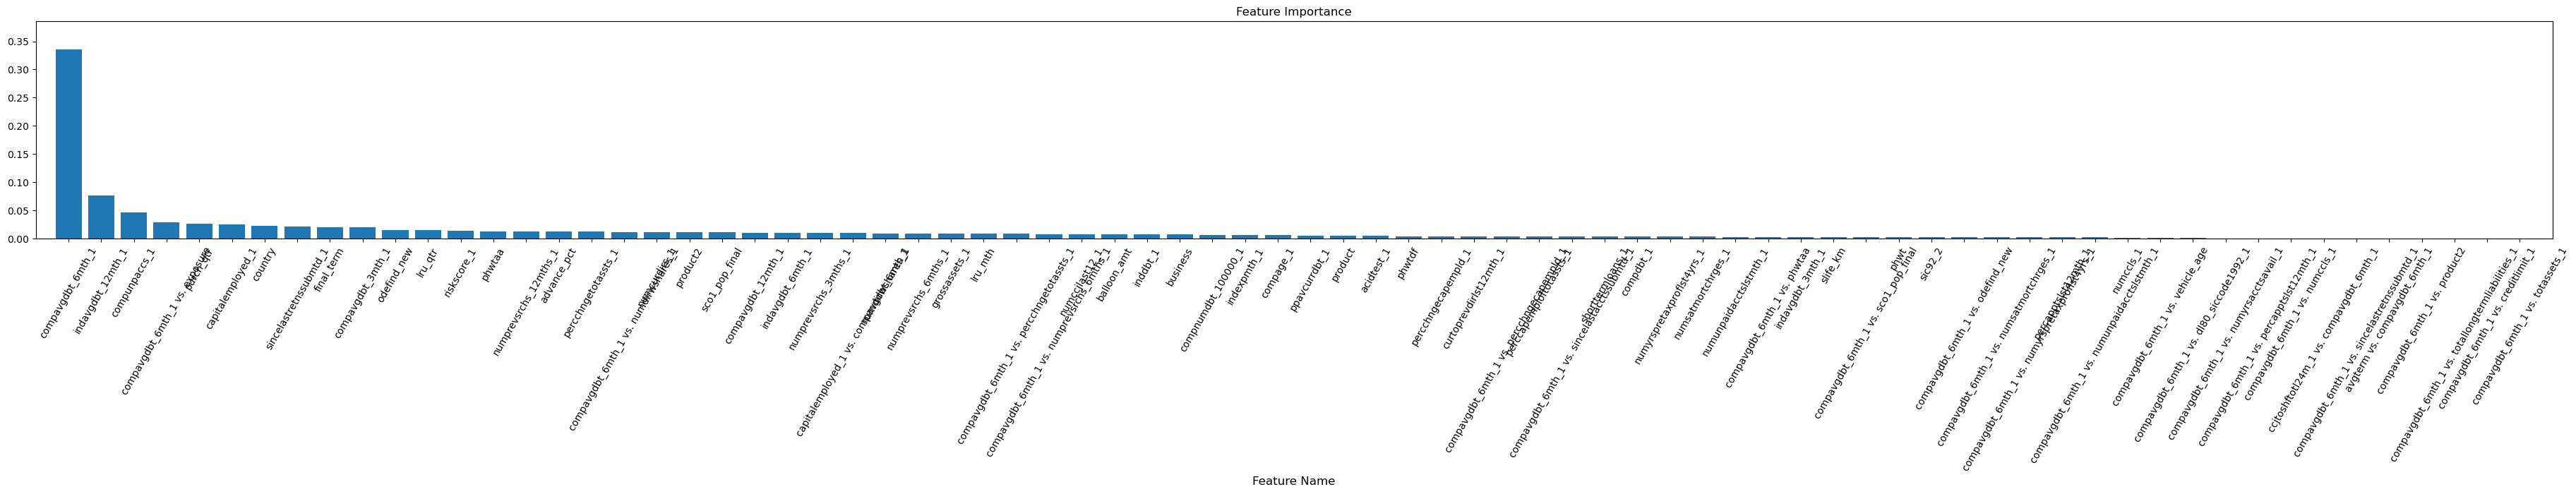

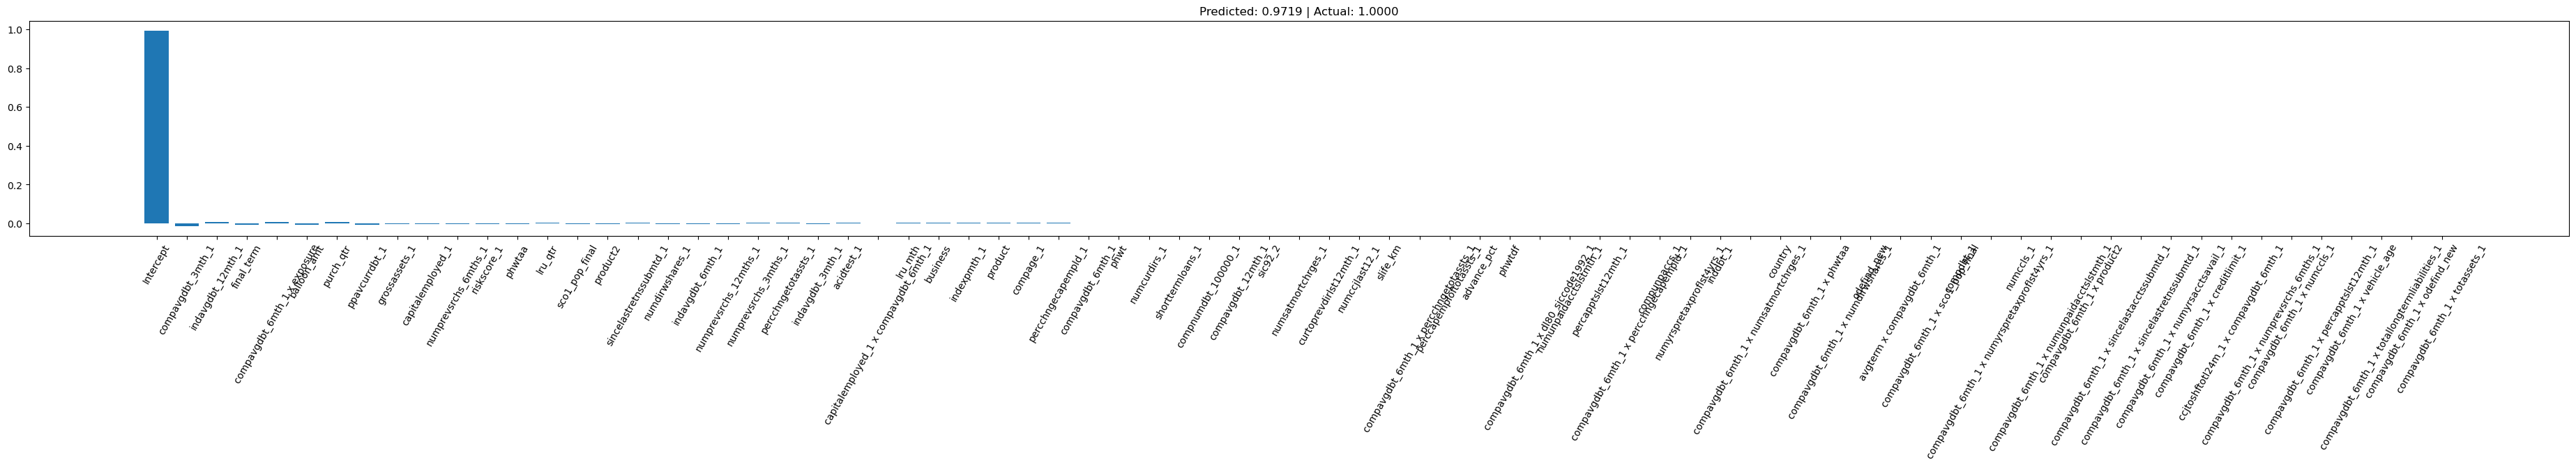

In [13]:
feature_importance_visualize(data_dict_global)
data_dict_local = model.local_explain(test_x[[0]], test_y[[0]], save_dict=False)
local_visualize(data_dict_local[0], save_png=False)

In [14]:
model.save(folder="./", name="mod01")

In [15]:
pred_train = model.predict(train_x)
pred_test = model.predict(test_x)
print(r2_score(test_y, pred_test))
print(r2_score(train_y, pred_train))


0.8220658756899367
0.9609584875127568
